## Setup

In [ ]:
# 1) Clone & cd
!git clone https://github.com/alonlahav123/DSC291-CLIP-Dissect.git
%cd DSC291-CLIP-Dissect

# # 2) Install PyTorch & torchvision
# !pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu117

# 3) Install other deps
!pip install -r requirements.txt

# 3b) install these again (not sure why but this works)
!pip install tokenizer ftfy sentence-transformers huggingface-hub

# 4) Download the Broden dataset (images only) using
!bash dlbroden.sh

Cloning into 'DSC291-CLIP-Dissect'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 116 (delta 40), reused 115 (delta 39), pack-reused 0 (from 0)
Receiving objects: 100% (116/116), 15.95 MiB | 17.52 MiB/s, done.
Resolving deltas: 100% (40/40), done.
/content/DSC291-CLIP-Dissect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 65.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 3.3 M

In [ ]:
# 5) (Optional) Download Places-365 ResNet-18
# !bash dlzoo_example.sh

In [1]:
!pwd

/home/vpalaniappan/private/DSC291-CLIP-Dissect


In [1]:
%%bash
# 1) upload imagenet_val 2012 after downloading from imagenet website
# 2) extract + remove the .tar.gz to save space

## Imagenet_val setup

In [ ]:
%%bash
cd data/imagenet_val

# Create the devkit folder if it doesn’t exist
mkdir -p ILSVRC2012_devkit_t12/data

# Download a known‐good meta.mat
wget -O ILSVRC2012_devkit_t12/data/meta.mat \
  https://raw.githubusercontent.com/calebrob6/imagenet_validation/master/data/meta.mat

# Download the ground-truth labels (50 000 integers 1–1000)
wget -O ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt \
  https://raw.githubusercontent.com/calebrob6/imagenet_validation/master/data/ILSVRC2012_validation_ground_truth.txt


# Need to organize the 50000 images into 1000 class folders (downloaded dataset is a flat folder with all the images)
python3 <<'EOF'
import os, numpy as np, scipy.io, shutil

# 1) Hardcode the full paths to the new files:
meta_mat_path = os.path.expanduser('~/private/DSC291-CLIP-Dissect/data/imagenet_val/ILSVRC2012_devkit_t12/data/meta.mat')
gt_path       = os.path.expanduser('~/private/DSC291-CLIP-Dissect/data/imagenet_val/ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt')

# 2) Where your flat JPEGs live and where to write val_annotations.txt
flat_dir  = 'data/imagenet_val/images'
anns_file = 'data/imagenet_val/val_annotations.txt'

# 3) Load the 1 000 WNIDs from meta.mat
mat = scipy.io.loadmat(meta_mat_path, struct_as_record=False, squeeze_me=True)
wnids = [str(s.WNID) for s in mat['synsets']]

# 4) Load the 50 000 labels (values 1–1000)
gt = np.loadtxt(gt_path, dtype=int)

# 5) Sort the 50 000 flat JPEG filenames (match .JPEG or .jpeg)
imgs = sorted(f for f in os.listdir(flat_dir) if f.lower().endswith('.jpeg'))

# 6) Write val_annotations.txt linking each image to its WNID
with open(anns_file, 'w') as out:
    for img, lbl in zip(imgs, gt):
        out.write(f"{img}\t{wnids[lbl-1]}\n")

# 7) Move each JPEG into its synset subfolder
for line in open(anns_file):
    img, wnid = line.strip().split('\t')
    src = os.path.join(flat_dir, img)
    dst = os.path.join(flat_dir, wnid)
    os.makedirs(dst, exist_ok=True)
    shutil.move(src, os.path.join(dst, img))

print("✅ Done. Now have", len(os.listdir(flat_dir)), "folders under", flat_dir)
EOF


# Check to see that all the images are classfiied. 
ls data/imagenet_val/images | wc -l   # should print “1000”

## Run CLIP Dissect

In [2]:
!python describe_neurons.py \
  --clip_model ViT-B/16 \
  --target_model resnet50 \
  --d_probe imagenet_broden \
  --concept_set data/20k.txt \
  --pool_mode avg \
  --similarity_fn soft_wpmi \
  --batch_size 200 \
  --device cuda

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /tmp/xdg-cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 79.5MB/s]
100%|██████████████████████████████████████████| 64/64 [00:00<00:00, 132.16it/s]
torch.Size([64, 20000])
100%|████████████████████████████████████████| 256/256 [00:02<00:00, 123.31it/s]
torch.Size([256, 20000])
100%|████████████████████████████████████████| 512/512 [00:03<00:00, 131.48it/s]
torch.Size([512, 20000])
100%|██████████████████████████████████████| 1024/1024 [00:07<00:00, 137.65it/s]
torch.Size([1024, 20000])
100%|██████████████████████████████████████| 2048/2048 [00:15<00:00, 134.96it/s]
torch.Size([2048, 20000])


## Qualitative comparison

In [3]:
import os
#virtually move to parent directory
# os.chdir("..")

import torch
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt

import utils
import data_utils
import similarity
from experiments import text_colorings

## Settings

In [4]:
# Change this to select which figure is plotted
figure = 'fig1a'

settings = {'fig1a': {"target_name":'resnet50', "target_layer": 'layer1', "neurons_to_display": [46, 10, 242, 206]},
            'fig1b': {"target_name":'resnet50', "target_layer": 'layer4', "neurons_to_display": [1203, 1731, 683, 185]},
            'fig6a': {"target_name":'resnet18_places', "target_layer": 'layer4', "neurons_to_display": "NetDissect"},
            'fig6b': {"target_name":'resnet18_places', "target_layer": 'layer4', "neurons_to_display": "CLIP-Dissect"},
            'fig7a': {"target_name":'resnet50', "target_layer": 'layer4', "neurons_to_display": "NetDissect"},
            'fig7b': {"target_name":'resnet50', "target_layer": 'layer4', "neurons_to_display": "CLIP-Dissect"},
            'fig9a': {"target_name":'resnet50', "target_layer": 'layer1', "neurons_to_display": "NetDissect"},
            'fig9b': {"target_name":'resnet50', "target_layer": 'layer1', "neurons_to_display": "CLIP-Dissect"},
           }

target_name = settings[figure]["target_name"]
target_layer = settings[figure]["target_layer"]
neurons_to_display = settings[figure]["neurons_to_display"]

clip_name = 'ViT-B/16'
d_probe = 'imagenet_broden'
concept_set = 'data/20k.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi

## Run CLIP-Dissect

In [5]:
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer],
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size,
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

In [6]:
save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name,
                                                             text_save_name, similarity_fn, device=device)

with open(concept_set, 'r') as f:
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)

100%|██████████| 256/256 [00:02<00:00, 92.03it/s]


torch.Size([256, 20000])


## Visualize

In [7]:
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)

get_color = text_colorings.get_coloring(figure)

name_conversion = {'resnet50':'resnet50_imagenet', 'resnet18_places':'resnet18_places365'}
ood_names = {'resnet50':'p', 'resnet18_places': 'i'}

In [8]:
# Load Network Dissection results
netdissect_res = pd.read_csv('data/NetDissect_results/{}_{}.csv'.format(name_conversion[target_name],
                                                                       target_layer))
nd_ious = netdissect_res['score'].values
nd_labels = netdissect_res['label'].values

#Load MILAN results
milan_base = pd.read_csv('data/MILAN_results/m_base_{}.csv'.format(name_conversion[target_name]))
if target_name == 'resnet50':
    milan_ood = pd.read_csv('data/MILAN_results/m_places365_{}.csv'.format(name_conversion[target_name]))
elif target_name == 'resnet18_places':
    milan_ood = pd.read_csv('data/MILAN_results/m_imagenet_{}.csv'.format(name_conversion[target_name]))

milan_base = milan_base[milan_base['layer']==target_layer]
milan_base = milan_base.sort_values(by=['unit'])
milan_base = list(milan_base['description'])

milan_ood = milan_ood[milan_ood['layer']==target_layer]
milan_ood = milan_ood.sort_values(by=['unit'])
milan_ood = list(milan_ood['description'])

## Figure 1a (Reproduced Figure)

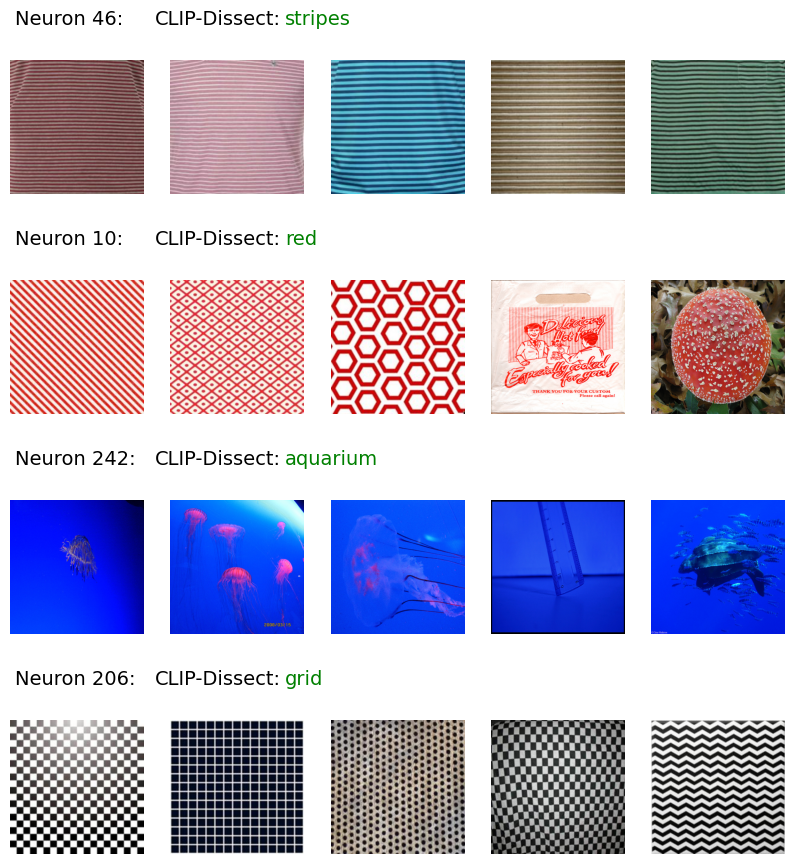

In [9]:
# Calculate which neurons to show
if type(neurons_to_display)==list:
    ids_to_check = neurons_to_display
if neurons_to_display == "CLIP-Dissect":
    ids_to_check = torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1][0:10]
elif neurons_to_display == "NetDissect":
    ids_to_check = torch.sort(torch.tensor(nd_ious), descending=True)[1][:10]


#plot figures
font_size=14
font = {'size'   : font_size}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, len(ids_to_check)*2.2])
subfigs = fig.subfigures(nrows=len(ids_to_check), ncols=1)
for j, orig_id in enumerate(ids_to_check):
    vals, ids = torch.topk(similarities[orig_id], k=5, largest=True)

    subfig = subfigs[j]
    subfig.text(0.13, 0.96, "Neuron {}:".format(int(orig_id)), size=font_size)
    subfig.text(0.27, 0.96, "CLIP-Dissect:", size=font_size)
    subfig.text(0.4, 0.96, words[int(ids[0])], size=font_size, color=get_color("clip", j))
    # subfig.text(0.53 ,0.96, "NetDissect:", size=font_size)
    # subfig.text(0.65 ,0.96, nd_labels[orig_id], size=font_size, color=get_color("nd", j))

    # subfig.text(0.13, 0.85, "MILAN(b):", size=font_size)
    # subfig.text(0.24, 0.85, milan_base[orig_id], size=font_size, color=get_color("milan_b", j))

    # subfig.text(0.53, 0.85, "MILAN({}):".format(ood_names[target_name]), size=font_size)
    # subfig.text(0.63, 0.85, milan_ood[orig_id], size=font_size, color=get_color("milan_ood", j))
    axs = subfig.subplots(nrows=1, ncols=5)
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        axs[i].imshow(im)
        axs[i].axis('off')
plt.show()

## Figure 1b (Reproduced Figure)

100%|██████████| 2048/2048 [00:23<00:00, 87.88it/s] 


torch.Size([2048, 20000])


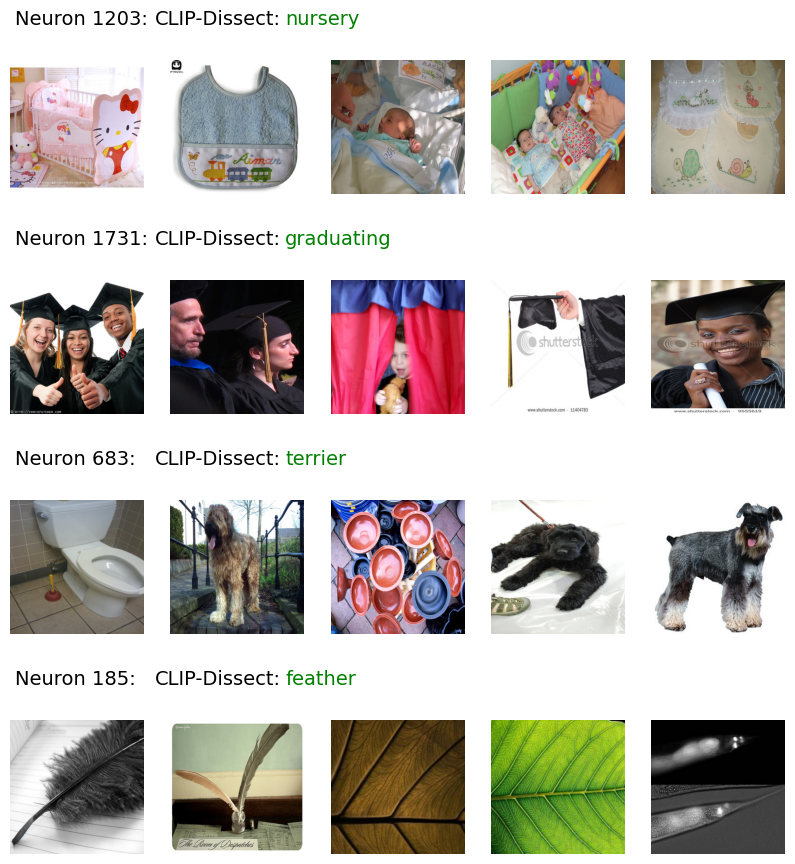

In [10]:
# Change this to select which figure is plotted
figure = 'fig1b'

settings = {'fig1a': {"target_name":'resnet50', "target_layer": 'layer1', "neurons_to_display": [46, 10, 242, 206]},
            'fig1b': {"target_name":'resnet50', "target_layer": 'layer4', "neurons_to_display": [1203, 1731, 683, 185]},
            'fig6a': {"target_name":'resnet18_places', "target_layer": 'layer4', "neurons_to_display": "NetDissect"},
            'fig6b': {"target_name":'resnet18_places', "target_layer": 'layer4', "neurons_to_display": "CLIP-Dissect"},
            'fig7a': {"target_name":'resnet50', "target_layer": 'layer4', "neurons_to_display": "NetDissect"},
            'fig7b': {"target_name":'resnet50', "target_layer": 'layer4', "neurons_to_display": "CLIP-Dissect"},
            'fig9a': {"target_name":'resnet50', "target_layer": 'layer1', "neurons_to_display": "NetDissect"},
            'fig9b': {"target_name":'resnet50', "target_layer": 'layer1', "neurons_to_display": "CLIP-Dissect"},
           }

target_name = settings[figure]["target_name"]
target_layer = settings[figure]["target_layer"]
neurons_to_display = settings[figure]["neurons_to_display"]

clip_name = 'ViT-B/16'
d_probe = 'imagenet_broden'
concept_set = 'data/20k.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi

utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer],
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size,
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name,
                                                             text_save_name, similarity_fn, device=device)

with open(concept_set, 'r') as f:
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)

top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)

get_color = text_colorings.get_coloring(figure)

name_conversion = {'resnet50':'resnet50_imagenet', 'resnet18_places':'resnet18_places365'}
ood_names = {'resnet50':'p', 'resnet18_places': 'i'}

# Load Network Dissection results
netdissect_res = pd.read_csv('data/NetDissect_results/{}_{}.csv'.format(name_conversion[target_name],
                                                                       target_layer))
nd_ious = netdissect_res['score'].values
nd_labels = netdissect_res['label'].values

#Load MILAN results
milan_base = pd.read_csv('data/MILAN_results/m_base_{}.csv'.format(name_conversion[target_name]))
if target_name == 'resnet50':
    milan_ood = pd.read_csv('data/MILAN_results/m_places365_{}.csv'.format(name_conversion[target_name]))
elif target_name == 'resnet18_places':
    milan_ood = pd.read_csv('data/MILAN_results/m_imagenet_{}.csv'.format(name_conversion[target_name]))

milan_base = milan_base[milan_base['layer']==target_layer]
milan_base = milan_base.sort_values(by=['unit'])
milan_base = list(milan_base['description'])

milan_ood = milan_ood[milan_ood['layer']==target_layer]
milan_ood = milan_ood.sort_values(by=['unit'])
milan_ood = list(milan_ood['description'])

# Calculate which neurons to show
if type(neurons_to_display)==list:
    ids_to_check = neurons_to_display
if neurons_to_display == "CLIP-Dissect":
    ids_to_check = torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1][0:10]
elif neurons_to_display == "NetDissect":
    ids_to_check = torch.sort(torch.tensor(nd_ious), descending=True)[1][:10]


#plot figures
font_size=14
font = {'size'   : font_size}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, len(ids_to_check)*2.2])
subfigs = fig.subfigures(nrows=len(ids_to_check), ncols=1)
for j, orig_id in enumerate(ids_to_check):
    vals, ids = torch.topk(similarities[orig_id], k=5, largest=True)

    subfig = subfigs[j]
    subfig.text(0.13, 0.96, "Neuron {}:".format(int(orig_id)), size=font_size)
    subfig.text(0.27, 0.96, "CLIP-Dissect:", size=font_size)
    subfig.text(0.4, 0.96, words[int(ids[0])], size=font_size, color=get_color("clip", j))
    # subfig.text(0.53 ,0.96, "NetDissect:", size=font_size)
    # subfig.text(0.65 ,0.96, nd_labels[orig_id], size=font_size, color=get_color("nd", j))

    # subfig.text(0.13, 0.85, "MILAN(b):", size=font_size)
    # subfig.text(0.24, 0.85, milan_base[orig_id], size=font_size, color=get_color("milan_b", j))

    # subfig.text(0.53, 0.85, "MILAN({}):".format(ood_names[target_name]), size=font_size)
    # subfig.text(0.63, 0.85, milan_ood[orig_id], size=font_size, color=get_color("milan_ood", j))
    axs = subfig.subplots(nrows=1, ncols=5)
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        axs[i].imshow(im)
        axs[i].axis('off')
plt.show()